TODOS:
- probably there is a bug: outout_flows are omitted if there is no output node, that means there is no constraint input==output, but the size constraint is missing then right?
- add coefficients
- Storage
- FixedOutput
- Proportion
- other solvers
    - ~~gurobi: unsupported python version~~
    - highs: weird error... :-/
- dimension location

In [1]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/home/p/HiGHS/build/bin"
os.environ['GRB_LICENSE_FILE'] = '/opt/gurobi810/gurobi.lic'

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import linopy
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout


In [3]:
class Node:
    def __init__(self, name, inputs, costs, input_proportions=None):
        self.name = name
        self.inputs = inputs
        self.outputs = None

        self.input_flows = None
        self.output_flows = None

        # TODO some nodes do not need size/costs, e.g. curtailing etc, but setting costs=0 is doing the job, but it creates some unnecessary variables
        self.size = None
        self.costs = costs

        if input_proportions is not None:
            assert input_proportions.keys() == {input_.name for input_ in inputs}, f"wrong parameter for node {name}: input_proportions needs to be a dict with keys matching names of inputs"
            # is this check too strict due to numerical errors?
            assert sum(input_proportions.values()) == 1., f"wrong parameter for node {name}: input_proportions needs to sum up to 1."

        self.input_proportions = input_proportions


In [4]:
class NodeFixInput(Node):
    # input is a fixed constant with dims location/time
    # this is use for input time series at the top of the tree
    #
    # size is determined by optimization model, if costs is not None, otherwise input is not scaled!
    # this might limit flexibility a bit
    def __init__(self, name, input_flow, costs=None):
        self.name = name
        self.inputs = []
        self.outputs = None

        self.input_flows =  {'': input_flow}
        self.output_flows = None

        assert (
            costs != 0.0
        ), "costs equal zero, this does not make sense here I guess? maybe use different node type?"

        self.size = None
        self.costs = costs


In [5]:
class NodeProportion(Node):
    # methanol production
    # for each input: percentage, should sum to 1 or to 100, then an equation is added for each input
    ...


In [6]:
class NodeStorage(Node):
    # usage example:
    #  - h2 storage
    #  - battery
    #  - co2

    # planned features:
    #  - charging/discharging speed
    #  - size
    #  - storage loss
    #  - discharging loss (also charging loss?)

    # TODO not yet implemented
    ...


In [7]:
class NodeFixOutput(Node):
    # output is fixed with dims location/time
    # usage example is to fix demand by use of a time series

    # TODO not yet implemented
    ...


In [39]:
# TODO this should be an input for Flow and maybe use a datetime range as coords
NUM_TIME_STEPS = 8760
time = pd.date_range(2020, freq="h", periods=8760)

In [40]:
class System:
    # basically a list of all technologies
    def __init__(self, nodes):
        self.nodes = nodes
        self.nodes_dict = {node.name for node in nodes}
        self.graph = self._create_graph(nodes)
        self.model = self._generate_optimization_model(nodes)

    def _create_graph(self, nodes):
        graph = nx.DiGraph()
        for node in nodes:
            if isinstance(node, NodeFixInput):
                color = "red"
            else:
                color = "blue"
            graph.add_node(node.name, color=color)
            for input_ in node.inputs:
                graph.add_edge(input_.name, node.name)
        return graph

    def _generate_optimization_model(self, nodes):
        model = linopy.Model()

        for node in nodes:
            # TODO atm some nodes should not have variables, but setting costs to 0 does the job too
            if node.costs:  # None or 0 means that we don't need a size variable
                node.size = model.add_variables(name=f"size_{node.name}", lower=0)

        # XXX not sure if we really need this backward connection, also in won't work as soon as we add demand
        for node in nodes:
            for input_ in node.inputs:
                if input_.outputs is None:
                    input_.outputs = []
                input_.outputs.append(node)

        # each input_flow is a variable (representing the amount of energy in the edge coming from input to self)
        for node in nodes:
            if node.input_flows is None:
                # FIXME we need a check for uniqueness of name somewhere
                node.input_flows = {
                    input_.name: model.add_variables(
                        name=f"flow_{input_.name}_{node.name}",
                        lower=xr.DataArray(
                            np.zeros(NUM_TIME_STEPS),
                            coords={"time": np.arange(NUM_TIME_STEPS)},
                        ),
                    )
                    for input_ in node.inputs
                }
            else:
                if node.size is not None:
                    node.input_flows[''] = node.size * node.input_flows['']

        # this is a bit weird: we want a variable or constant for each edge, but we store it as dict for all input connections and as list for all output connections
        for node in nodes:
            if node.output_flows is None and node.outputs is not None:
                node.output_flows = [
                    output.input_flows[node.name] for output in node.outputs
                ]

        # constraint: sum of inputs = sum of outputs
        for node in nodes:
            if node.output_flows is not None:
                if isinstance(node, NodeFixInput) and isinstance(node.input_flows[''], xr.DataArray):
                    # this if is needed because linopy wants all variables on one side and the constants on the other side...
                    # XXX this is super weird... without multiplying by 1, the left-hand-side is of wrong type, probably because there is only one thing in the summation!
                    model.add_constraints(
                        1.0 * sum(node.output_flows) == sum(node.input_flows.values())
                    )
                else:
                    model.add_constraints(
                        1.0 * sum(node.output_flows) - sum(node.input_flows.values())
                        == 0
                    )

        # constraint: size of technology
        for node in nodes:
            if node.output_flows is not None and node.size:
                model.add_constraints(sum(node.output_flows) - node.size <= 0)

        # constraint: proportion of inputs
        for node in nodes:
            if hasattr(node, 'input_proportions') and node.input_proportions is not None:
                total_input = sum(node.input_flows.values())
                for name, proportion in node.input_proportions.items():
                    model.add_constraints(proportion * total_input - node.input_flows[name] == 0.)

        # storage?

        model.add_objective(self.total_costs())

        return model

    def optimize(self, solver="glpk"):
        self.model.solve(solver_name=solver)

    def total_costs(self):
        return sum(node.size * node.costs for node in self.nodes if node.costs)

    def draw(self):
        nx.draw(
            self.graph,
            pos=graphviz_layout(self.graph, prog="dot"),
            node_color=[
                node_attrs["color"] for _, node_attrs in self.graph.nodes(data=True)
            ],
            # node_size=5000,
            with_labels=True,
        )


## User interface starts here

In [41]:
np.random.seed(42)


def random_time_series():
    return xr.DataArray(
        np.random.rand(NUM_TIME_STEPS),
        dims="time",
        coords={"time": np.arange(NUM_TIME_STEPS)},
    )


solar_pv = NodeFixInput(name="solar_pv", input_flow=random_time_series(), costs=10)
wind = NodeFixInput(name="wind", input_flow=random_time_series(), costs=5)
co2 = NodeFixInput(name="co2", input_flow=random_time_series())

curtail = Node(name="curtail", inputs=[solar_pv, wind], costs=0)
hydrogen = Node(name="hydrogen", inputs=[solar_pv, wind], costs=7)
#curtail_h2 = Node(name="curtail_h2", inputs=[hydrogen], costs=0)
methanol_synthesis = Node(
    name="methanol_synthesis", inputs=[co2, hydrogen], costs=8, input_proportions={'co2': 0.25, 'hydrogen': 0.75}
)


In [42]:
system = System([solar_pv, wind, curtail, hydrogen, co2, methanol_synthesis])

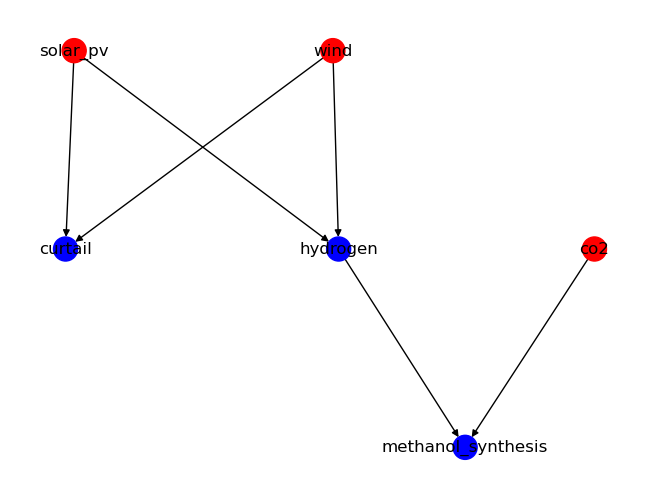

In [43]:
system.draw()


In [44]:
# system.optimize() #'highs')

In [45]:
system.optimize('gurobi')

Writing variables.: 100%|██████████| 10/10 [00:00<00:00, 67.58it/s]


skipping further warning of this kind
Read LP format model from file /tmp/linopy-problem-guxo28w8.lp
Reading time = 0.35 seconds
obj: 70080 rows, 52564 columns, 166440 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 70080 rows, 52564 columns and 166440 nonzeros
Model fingerprint: 0x7ee46a3e
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [5e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-05, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 43800 rows and 35042 columns
Presolve time: 0.23s
Presolved: 26280 rows, 17522 columns, 70080 nonzeros

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 2
 AA' NZ     : 5.256e+04
 Factor NZ  : 1.051e+05 (roughly 20 MB of memory)
 Factor Ops : 4.380e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objec

In [59]:
system.model.solution

# why is hydrogen 0?
# why is methanol 0?

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [ ]:
system.model

Linopy model

Variables:
----------
Dimensions:                           (time: 8760)
Coordinates:
  * time                              (time) int64 0 1 2 3 ... 8757 8758 8759
Data:
    size_solar_pv                     int64 0
    size_wind                         int64 1
    size_hydrogen                     int64 2
    size_methanol_synthesis           int64 3
    flow_solar_pv_curtail             (time) int64 4 5 6 7 ... 8761 8762 8763
    flow_wind_curtail                 (time) int64 8764 8765 ... 17522 17523
    flow_solar_pv_hydrogen            (time) int64 17524 17525 ... 26282 26283
    flow_wind_hydrogen                (time) int64 26284 26285 ... 35042 35043
    flow_co2_methanol_synthesis       (time) int64 35044 35045 ... 43802 43803
    flow_hydrogen_methanol_synthesis  (time) int64 43804 43805 ... 52562 52563

Constraints:
------------
Dimensions:  (time: 8760)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 8753 8754 8755 8756 8757 8758 8759
Data:
    con0

## A small linopy Example to try out things

In [188]:
m = linopy.Model()

In [189]:
wind = xr.DataArray(np.random.rand(NUM_TIME_STEPS), dims="time")
pv = xr.DataArray(np.random.rand(NUM_TIME_STEPS), dims="time")
demand = xr.DataArray(np.random.rand(NUM_TIME_STEPS), dims="time")

In [190]:
wind_size = m.add_variables(name="wind_size")
pv_size = m.add_variables(name="pv_size")

In [191]:
wind_size * wind


Linear Expression with 1 term(s):
----------------------------------

Dimensions:  (time: 8760, _term: 1)
Dimensions without coordinates: time, _term
Data:
    coeffs   (time, _term) float64 0.9355 0.3921 0.4742 ... 0.4892 0.1576 0.6927
    vars     (time, _term) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

In [192]:
pv_size + np.array(1.0)



Linear Expression with 2 term(s):
----------------------------------

Dimensions:  (_term: 2)
Dimensions without coordinates: _term
Data:
    coeffs   (_term) int64 1 1
    vars     (_term) int64 1 1

In [195]:
m.add_constraints(wind_size * wind + pv_size * pv >= demand)

Constraint 'con0':
------------------

Constraint labels:
array([   0,    1,    2, ..., 8757, 8758, 8759])
Dimensions without coordinates: time

In [196]:
m.add_objective(wind_size + 2 * pv_size)


Linear Expression with 2 term(s):
----------------------------------

Dimensions:  (_term: 2)
Dimensions without coordinates: _term
Data:
    coeffs   (_term) int64 1 2
    vars     (_term) int64 0 1

In [197]:
m.solve(solver_name="glpk")



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-yzd3v74j.lp --output /tmp/linopy-solve-6tcmsttn.sol
Reading problem data from '/tmp/linopy-problem-yzd3v74j.lp'...
8760 rows, 2 columns, 17520 non-zeros
52580 lines were read
GLPK Simplex Optimizer 5.0
8760 rows, 2 columns, 17520 non-zeros
Preprocessing...
8760 rows, 2 columns, 17520 non-zeros
Scaling...
 A: min|aij| =  6.000e-06  max|aij| =  1.000e+00  ratio =  1.667e+05
GM: min|aij| =  4.484e-03  max|aij| =  2.230e+02  ratio =  4.974e+04
EQ: min|aij| =  2.010e-05  max|aij| =  1.000e+00  ratio =  4.974e+04
Constructing initial basis...
Size of triangular part is 8760
      0: obj =   0.000000000e+00 inf =   7.966e+03 (8760)
   5736: obj =   1.459140927e+00 inf =   3.892e+03 (3018) 56
   8756: obj =   3.377650392e+02 inf =   0.000e+00 (0) 30
OPTIMAL LP SOLUTION FOUND
Time used:   7.6 secs
Memory used: 8.2 Mb (8636351 bytes)
Writing basic solution to '/tmp/linopy-solve-6tcmsttn.sol'...


('ok', 'optimal')